In [3]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PowerTransformer

import lightgbm as lgbm


In [4]:
sys.path.append('../../')
import src.utils as utils

In [5]:
EXP_NUM = 1

In [6]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
TRAIN_DIR = MAIN_DATA_DIR / 'train'
OUTPUT_DIR = Path('./output/')

In [7]:
players = pd.read_csv(MAIN_DATA_DIR / 'players.csv')

rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()
seasons = pd.read_csv(MAIN_DATA_DIR / 'seasons.csv')


In [8]:
seasons = seasons.fillna('1970-01-01')
for c_ in seasons.columns[1:]:
    seasons[c_] = pd.to_datetime(seasons[c_].str.replace('-', '').astype(int), format="%Y%m%d")

In [9]:
seasons

,seasonId,seasonStartDate,seasonEndDate,preSeasonStartDate,preSeasonEndDate,regularSeasonStartDate,regularSeasonEndDate,lastDate1stHalf,allStarDate,firstDate2ndHalf,postSeasonStartDate,postSeasonEndDate
0,2017,2017-04-02,2017-11-01,2017-02-22,2017-04-01,2017-04-02,2017-10-01,2017-07-09,2017-07-11,2017-07-14,2017-10-03,2017-11-01
1,2018,2018-03-29,2018-10-28,2018-02-21,2018-03-27,2018-03-29,2018-10-01,2018-07-15,2018-07-17,2018-07-19,2018-10-02,2018-10-28
2,2019,2019-03-20,2019-10-30,2019-02-21,2019-03-26,2019-03-20,2019-09-29,2019-07-07,2019-07-09,2019-07-11,2019-10-01,2019-10-30
3,2020,2020-07-23,2020-10-28,2020-02-21,2020-07-22,2020-07-23,2020-09-27,2020-08-25,1970-01-01,2020-08-26,2020-09-29,2020-10-28
4,2021,2021-02-28,2021-10-31,2021-02-28,2021-03-30,2021-04-01,2021-10-03,2021-07-11,2021-07-13,2021-07-15,2021-10-04,2021-10-31


In [10]:
targets = targets.merge(scores, on=['playerId', 'date'], how='left')

In [11]:
def extract_season(date_raw, season_start_end):
    idxes = 0
    for raw in season_start_end.iloc():
        idx_ = ((date_raw >= raw.iloc[0]) & (date_raw <= raw.iloc[1])) * 1
        idxes += idx_
    return idxes

In [12]:
seasons[['seasonStartDate', 'seasonEndDate']]

,seasonStartDate,seasonEndDate
0,2017-04-02,2017-11-01
1,2018-03-29,2018-10-28
2,2019-03-20,2019-10-30
3,2020-07-23,2020-10-28
4,2021-02-28,2021-10-31


In [13]:
## only on season
on_whole_idxes = extract_season(pd.to_datetime(targets['date'], format="%Y%m%d"), seasons[['seasonStartDate', 'seasonEndDate']])
targets = targets[on_whole_idxes == 1].reset_index(drop=True)

In [14]:
targets['gameday'] = ~targets['battingOrder'].isna()*1

<AxesSubplot:xlabel='gameday', ylabel='target1'>

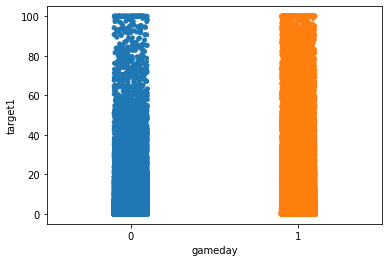

In [15]:
sns.stripplot(x="gameday", y="target1", data=targets)

(0.0, 20.0)

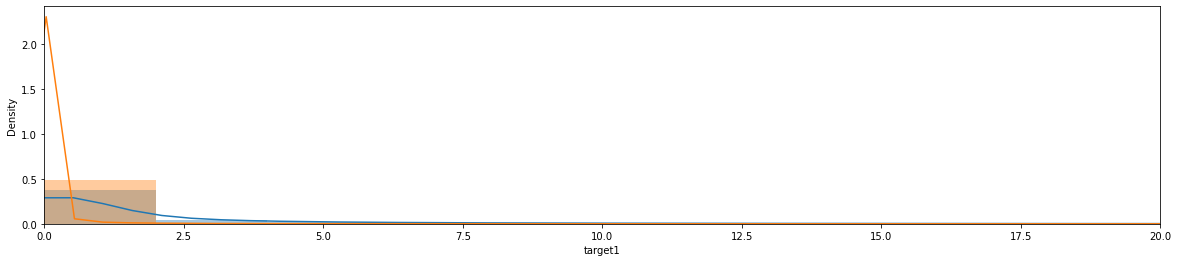

In [16]:
plt.figure(figsize=(20, 4))
sns.distplot(targets[targets['gameday']==1]['target1'])
sns.distplot(targets[targets['gameday']==0]['target1'])
plt.xlim((0, 20))

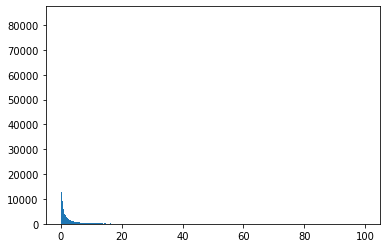

,count,mean,std,min,25%,50%,75%,max
target1,182576.0,3.319307,9.979293,0.0,0.012132,0.314775,1.99275,100.0


In [17]:
plt.hist(targets[targets['gameday'] == 1]['target1'], bins=500)
plt.show()
pd.DataFrame(targets[targets['gameday'] == 1]['target1']).describe().T

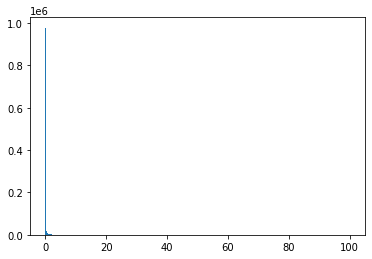

,count,mean,std,min,25%,50%,75%,max
target1,1051963.0,0.251233,2.519652,0.0,0.0,0.000338,0.004334,100.0


In [18]:
plt.hist(targets[targets['gameday'] == 0]['target1'], bins=500)
plt.show()
pd.DataFrame(targets[targets['gameday'] == 0]['target1']).describe().T

In [19]:
targets[(targets['gameday'] == 0) & (targets['target1'] == 100)]

,engagementMetricsDate,playerId,target1,target2,target3,target4,index_x,date,home,gamePk,...,sacFliesPitching,saves,holds,blownSaves,assists,putOuts,errors,chances,index_y,gameday
3110,2018-03-31,400085,100.0,58.754188,56.835467,100.000000,88,20180330,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
36085,2018-04-16,592450,100.0,88.558306,20.232832,14.533902,104,20180415,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
41425,2018-04-19,518792,100.0,19.722528,20.450886,8.057999,107,20180418,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
52292,2018-04-24,519144,100.0,30.519114,2.719682,9.656489,112,20180423,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
66327,2018-05-01,645277,100.0,42.446391,7.956336,19.143196,119,20180430,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166649,2021-03-30,641355,100.0,25.102881,0.373461,10.266812,1183,20210329,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1170406,2021-03-31,605141,100.0,25.050011,1.320544,13.088908,1184,20210330,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1170995,2021-04-01,408234,100.0,87.248645,50.133591,63.590085,1185,20210331,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1175634,2021-04-03,596142,100.0,10.607987,1.496474,8.109946,1187,20210402,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [20]:
targets[(targets['playerId'] == 660271)]

,engagementMetricsDate,playerId,target1,target2,target3,target4,index_x,date,home,gamePk,...,sacFliesPitching,saves,holds,blownSaves,assists,putOuts,errors,chances,index_y,gameday
1479,2018-03-30,594798,0.017601,8.744300,0.110688,0.892602,87,20180329,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2089,2018-03-31,594798,7.656514,63.736196,0.166455,8.403129,88,20180330,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5644,2018-04-01,594798,3.295736,3.458651,0.079375,2.903353,89,20180331,1.0,529443.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,89.0,1
7632,2018-04-02,594798,0.063533,3.944540,0.073217,2.637051,90,20180401,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8932,2018-04-03,594798,0.020648,3.236665,0.109913,1.960574,91,20180402,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224514,2021-04-27,594798,5.484699,32.399914,3.537350,24.054706,1211,20210426,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1226471,2021-04-28,594798,9.656066,100.000000,18.468399,100.000000,1212,20210427,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1228561,2021-04-29,594798,19.667361,82.311547,23.870407,65.194055,1213,20210428,1.0,634310.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1213.0,1
1230638,2021-04-30,594798,5.575402,33.871954,5.607469,26.930590,1214,20210429,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [21]:
players[players['playerId'] == 660271]

,playerId,playerName,DOB,mlbDebutDate,birthCity,birthStateProvince,birthCountry,heightInches,weight,primaryPositionCode,primaryPositionName,playerForTestSetAndFuturePreds
798,660271,Shohei Ohtani,1994-07-05,2018-03-29,Oshu,NaN,Japan,76,210,1,Pitcher,True


In [ ]:
player_target_stats = pd.read_csv(MAIN_DATA_DIR / "player_target_stats.csv")

In [ ]:
player_ids = targets['playerId'].unique()

In [ ]:
id_ = player_ids[1000]
# id_ = 600921

In [ ]:
target_oneplayer = targets[targets['playerId']==id_]

In [ ]:
player_target_stats[player_target_stats['playerId']==id_]

In [ ]:
plt.figure(figsize=(15, 4))
for i in range(len(seasons)):
    plt.axvspan(seasons['preSeasonStartDate'][i], seasons['preSeasonEndDate'][i], color="gray", alpha=0.3)
for i in range(len(seasons)):
    plt.axvspan(seasons['regularSeasonStartDate'][i], seasons['regularSeasonEndDate'][i], color="orange", alpha=0.3)
for i in range(len(seasons)):
    plt.axvspan(seasons['postSeasonStartDate'][i], seasons['postSeasonEndDate'][i], color="gray", alpha=0.3)
dates = pd.to_datetime(target_oneplayer['date'], format="%Y%m%d").values
plt.plot(dates, target_oneplayer['target1'].values)
plt.xlim(np.min(dates), np.max(dates))

In [ ]:
plt.figure(figsize=(15, 4))
for i in range(len(seasons)):
    plt.axvspan(seasons['preSeasonStartDate'][i], seasons['preSeasonEndDate'][i], color="gray", alpha=0.3)
for i in range(len(seasons)):
    plt.axvspan(seasons['regularSeasonStartDate'][i], seasons['regularSeasonEndDate'][i], color="orange", alpha=0.3)
for i in range(len(seasons)):
    plt.axvspan(seasons['postSeasonStartDate'][i], seasons['postSeasonEndDate'][i], color="gray", alpha=0.3)
dates = pd.to_datetime(target_oneplayer['date'], format="%Y%m%d").values
plt.plot(dates, target_oneplayer['target2'].values)
plt.xlim(np.min(dates), np.max(dates))

In [ ]:
plt.figure(figsize=(15, 4))
for i in range(len(seasons)):
    plt.axvspan(seasons['preSeasonStartDate'][i], seasons['preSeasonEndDate'][i], color="gray", alpha=0.3)
for i in range(len(seasons)):
    plt.axvspan(seasons['regularSeasonStartDate'][i], seasons['regularSeasonEndDate'][i], color="orange", alpha=0.3)
for i in range(len(seasons)):
    plt.axvspan(seasons['postSeasonStartDate'][i], seasons['postSeasonEndDate'][i], color="gray", alpha=0.3)
dates = pd.to_datetime(target_oneplayer['date'], format="%Y%m%d").values
plt.plot(dates, target_oneplayer['target3'].values)
plt.xlim(np.min(dates), np.max(dates))

In [ ]:
plt.figure(figsize=(15, 4))
for i in range(len(seasons)):
    plt.axvspan(seasons['preSeasonStartDate'][i], seasons['preSeasonEndDate'][i], color="gray", alpha=0.3)
for i in range(len(seasons)):
    plt.axvspan(seasons['regularSeasonStartDate'][i], seasons['regularSeasonEndDate'][i], color="orange", alpha=0.3)
for i in range(len(seasons)):
    plt.axvspan(seasons['postSeasonStartDate'][i], seasons['postSeasonEndDate'][i], color="gray", alpha=0.3)
dates = pd.to_datetime(target_oneplayer['date'], format="%Y%m%d").values
plt.plot(dates, target_oneplayer['target4'].values)
plt.xlim(np.min(dates), np.max(dates))

## target2, 4は0の区間が多い気がする

In [ ]:
targets = pd.merge(targets, scores, how='left', on=['playerId', 'date']) 
date_ = pd.to_datetime(targets['date'], format="%Y%m%d")
targets['month'] = date_.dt.month

In [ ]:
targets['gameday'] = targets['battingOrder'].isna()*1

In [ ]:
targets[targets['gameday']==0]

In [ ]:
plt.figure(figsize=(15, 8))
sns.violinplot(x="month", y="target1", data=targets)

In [ ]:
sns.violinplot(x="gameday", y="target2", data=targets)

In [ ]:
sns.violinplot(x="gameday", y="target3", data=targets)

In [ ]:
sns.violinplot(x="gameday", y="target4", data=targets)

In [ ]:
plt.hist(targets['target1'], bins=500)
plt.show()
pd.DataFrame(targets['target1']).describe().T

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(pd.to_datetime(targets['date'], format="%Y%m%d").values[::100], targets['target2'].values[::100])

In [ ]:
# targets.sort_values('target1', ascending=False)

In [ ]:
plt.hist(targets['target2'], bins=500)
plt.show()
pd.DataFrame(targets['target2']).describe().T

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(pd.to_datetime(targets['date'], format="%Y%m%d").values[::100], targets['target3'].values[::100])

In [ ]:
plt.hist(targets['target3'], bins=500)
plt.show()
pd.DataFrame(targets['target3']).describe().T

In [2]:
plt.figure(figsize=(15, 4))
plt.plot(pd.to_datetime(targets['date'], format="%Y%m%d").values[::100], targets['target4'].values[::100])

NameError: name 'plt' is not defined

In [ ]:
plt.hist(targets['target4'], bins=500)
plt.show()
pd.DataFrame(targets['target4']).describe().T

In [ ]:
# pt = PowerTransformer()

In [ ]:
# target4_norm = pt.fit_transform(targets['target4'].values.reshape(-1,1)).reshape(-1)

In [ ]:
# plt.hist(target4_norm, bins=500)
# plt.show()
# pd.DataFrame(target4_norm).describe().T